<a href="https://colab.research.google.com/github/Leucocitokiller/Proyecto-Fina-NLP/blob/main/Proyecto_final_NLP_Redes_Neuronales_Libenson.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importación de Librerías.

In [1]:
import urllib.request
import numpy as np
import pandas as pd
import os
import time
import sys
#-----librerias para trabajar PLN
!python -m spacy download es_core_news_md
import spacy
import es_core_news_md
#es_core_news_md Medium (modelo mediano):
#Es más pesado y más lento que el sm, pero mucho más preciso. Tiene vectores de palabras, entiende mejor el significado de las palabras.

#-----instalación d librerias para análisis de sentimientos.
!pip install spacy spacy-transformers
!pip install pysentimiento
from pysentimiento import create_analyzer

#----librerias para normalización de textos
import re
from unicodedata import normalize
import unicodedata
from collections import Counter


#----librerias para graficar y wordcloud.
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns

#----librerías para trabajar con TF-IDF
from sklearn.feature_extraction.text import TfidfVectorizer
#----libreria para trabajar con BoW.
from sklearn.feature_extraction.text import CountVectorizer
#----librerias para Machine learning
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.3/42.3 MB 17.6 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('es_core_news_md')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 756.2/756.2 kB 12.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 314.0/314.0 kB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 41.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 17.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 18.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━

# Procesamiento de la Fuente de Datos.

## Conexión con la fuente de datos.


In [12]:
# Diccionario con las fuentes y sus URLs
filepath_dict = {
    'yelp': 'https://raw.githubusercontent.com/Leucocitokiller/Proyecto-Fina-NLP/main/yelp_comentarios.csv',
    'amazon': 'https://raw.githubusercontent.com/Leucocitokiller/Proyecto-Fina-NLP/main/amazon_cells_comentarios.csv'

}

df_list = []
for source, filepath in filepath_dict.items():
    df = pd.read_csv(filepath, names=['Comentario', 'Valor'], sep=';', encoding='latin-1')
    df['Origen'] = source  # Add another column filled with the source name
    df_list.append(df)

df = pd.concat(df_list)
df.head(1100)

,Comentario,Valor,Origen
0,Wow ... Me encantó este lugar.,1,yelp
1,La corteza no es buena.,0,yelp
2,No sabroso y la textura era simplemente desagr...,0,yelp
3,Me detuve durante las vacaciones de fines de m...,1,yelp
4,"La selección en el menú era genial, al igual q...",1,yelp
...,...,...,...
96,"Si planeas usar esto en un auto, olvídalo.",0,amazon
97,Encontré este producto demasiado grande.,0,amazon
98,Lo mejor que he encontrado hasta ahora ... He ...,1,amazon
99,Estoy muy decepcionado con mi decisión.,0,amazon


## Normalización de la Fuente de datos.


### Eliminación de signos de puntuación.

In [13]:
# Definición de función para eliminar los signos de puntuación utilizando re, pero considerando no borrar las vocales con acento.

def remove_punctuation(text):
    # Normaliza el texto a NFKD para separar letras y sus tildes
    text = unicodedata.normalize('NFKD', text)
    # Elimina los caracteres diacríticos (como las tildes)
    text = ''.join(c for c in text if not unicodedata.combining(c))
    # Elimina todo lo que no sea letras, números o espacios
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
    return text


# Aplicar la función a la columna 'review_lower'
df['Comentarios'] = df['Comentario'].apply(remove_punctuation)

In [14]:
df

,Comentario,Valor,Origen,Comentarios
0,Wow ... Me encantó este lugar.,1,yelp,Wow Me encanto este lugar
1,La corteza no es buena.,0,yelp,La corteza no es buena
2,No sabroso y la textura era simplemente desagr...,0,yelp,No sabroso y la textura era simplemente desagr...
3,Me detuve durante las vacaciones de fines de m...,1,yelp,Me detuve durante las vacaciones de fines de m...
4,"La selección en el menú era genial, al igual q...",1,yelp,La seleccion en el menu era genial al igual qu...
...,...,...,...,...
995,La pantalla se mancha fácilmente porque toca l...,0,amazon,La pantalla se mancha facilmente porque toca l...
996,Qué pedazo de chatarra ... Pierdo más llamadas...,0,amazon,Que pedazo de chatarra Pierdo mas llamadas en...
997,El artículo no coincide con la imagen.,0,amazon,El articulo no coincide con la imagen
998,Lo Ãºnico que me decepcionó es el puerto infra...,0,amazon,Lo Aonico que me decepciono es el puerto infra...


### Reducir a minúsculas el texto.

In [15]:
# Create a new column 'Comentarios_lower' with lowercase values from 'Comentario'
df['Comentarios_lower'] = df['Comentarios'].str.lower()

In [16]:
df

,Comentario,Valor,Origen,Comentarios,Comentarios_lower
0,Wow ... Me encantó este lugar.,1,yelp,Wow Me encanto este lugar,wow me encanto este lugar
1,La corteza no es buena.,0,yelp,La corteza no es buena,la corteza no es buena
2,No sabroso y la textura era simplemente desagr...,0,yelp,No sabroso y la textura era simplemente desagr...,no sabroso y la textura era simplemente desagr...
3,Me detuve durante las vacaciones de fines de m...,1,yelp,Me detuve durante las vacaciones de fines de m...,me detuve durante las vacaciones de fines de m...
4,"La selección en el menú era genial, al igual q...",1,yelp,La seleccion en el menu era genial al igual qu...,la seleccion en el menu era genial al igual qu...
...,...,...,...,...,...
995,La pantalla se mancha fácilmente porque toca l...,0,amazon,La pantalla se mancha facilmente porque toca l...,la pantalla se mancha facilmente porque toca l...
996,Qué pedazo de chatarra ... Pierdo más llamadas...,0,amazon,Que pedazo de chatarra Pierdo mas llamadas en...,que pedazo de chatarra pierdo mas llamadas en...
997,El artículo no coincide con la imagen.,0,amazon,El articulo no coincide con la imagen,el articulo no coincide con la imagen
998,Lo Ãºnico que me decepcionó es el puerto infra...,0,amazon,Lo Aonico que me decepciono es el puerto infra...,lo aonico que me decepciono es el puerto infra...


### Convertir a número la columna Valor para su postprocesamiento.

In [17]:
# Convertimos la columna rating a valor numérico
df['Valor'] = pd.to_numeric(df['Valor'], errors='coerce')

In [18]:
df['Valor']

,Valor
0,1
1,0
2,0
3,1
4,1
...,...
995,0
996,0
997,0
998,0


# NLP

## Pre Procesamiento.

### Generación del objeto de SPacy para utilizar en el procesamiento del texto en español.

In [19]:
nlp = es_core_news_md.load()

### Convertir texto a minúsculas y Tokenización.

In [21]:
df['Comentarios_tokenizados'] = df['Comentarios_lower'].apply(lambda text: nlp(text))
df[['Comentarios_lower','Comentarios_tokenizados']].head()

,Comentarios_lower,Comentarios_tokenizados
0,wow me encanto este lugar,"(wow, , me, encanto, este, lugar)"
1,la corteza no es buena,"(la, corteza, no, es, buena)"
2,no sabroso y la textura era simplemente desagr...,"(no, sabroso, y, la, textura, era, simplemente..."
3,me detuve durante las vacaciones de fines de m...,"(me, detuve, durante, las, vacaciones, de, fin..."
4,la seleccion en el menu era genial al igual qu...,"(la, seleccion, en, el, menu, era, genial, al,..."


### Remoción de StopWords

In [24]:
# Lista de palabras que NO queremos eliminar (tienen carga emocional)
palabras_sentimiento = {
    # Positivas
    "bueno", "buena","si","buenísimo", "excelentes", "excelente", "genial", "maravilloso", "maravilla", "fantástico", "fabuloso", "increíble",
    "perfecto", "perfecta", "agradable", "satisfecho", "satisfecha", "contento", "contenta", "encantado", "encantada",
    "amable", "simpático", "simpática", "rápido", "rápida", "cómodo", "cómoda", "eficaz", "eficiente", "fácil",
    "recomendable", "ideal", "espectacular", "feliz", "brillante", "cumplió", "cumple", "funciona", "funciona bien",
    "inmejorable", "confiable", "duradero", "cumplidor", "seguro", "preciso", "elegante", "atento", "responsable",
    "acertado", "destacado", "excepcional", "impecable", "sensacional", "útil", "accesible", "económico", "funcional",
    "intuitivo", "conveniente", "hermoso", "linda", "precioso", "excelente calidad", "vale la pena",

    # Negativas
    "malo","no", "mala", "mal", "pésimo", "pésima","nunca", "horrible", "fatal", "insoportable", "lento", "lenta", "incómodo", "incómoda",
    "decepcionante", "decepcionado", "decepcionada", "sucio", "sucia", "caro", "cara", "inútil", "deficiente", "desagradable",
    "complicado", "problemático", "estafa", "engañado", "engañada", "roto", "rota", "desastroso", "error", "errores",
    "retraso", "tardanza", "frágil", "inestable", "poco fiable", "nunca más", "no volveré", "no recomiendo", "no sirve",
    "no funciona", "arruinado", "falló", "fallando", "demora", "pésima atención", "servicio malo", "mala calidad", "molesto",
    "defecto", "problemas", "fallas", "sin sentido", "basura", "pérdida de dinero", "decepción"
}

# Actualizamos spaCy para que NO considere esas palabras como stopwords
for palabra in palabras_sentimiento:
    lex = nlp.vocab[palabra]
    lex.is_stop = False



def parse_and_remove_stopwords(doc):
    """
    Remueve las stopwords de un objeto spaCy Doc.
    """
    # Filtrar stopwords y obtener los tokens como texto
    tokens_filtrados = [token.text for token in doc if not token.is_stop]
    return tokens_filtrados

# Aplicar la función al DataFrame
df['Comentarios_sin_StopWords'] = df['Comentarios_tokenizados'].apply(parse_and_remove_stopwords)

df[['Comentarios_tokenizados','Comentarios_sin_StopWords']].head()

,Comentarios_tokenizados,Comentarios_sin_StopWords
0,"(wow, , me, encanto, este, lugar)","[wow, , encanto, lugar]"
1,"(la, corteza, no, es, buena)","[corteza, no, buena]"
2,"(no, sabroso, y, la, textura, era, simplemente...","[no, sabroso, textura, simplemente, desagradable]"
3,"(me, detuve, durante, las, vacaciones, de, fin...","[detuve, vacaciones, fines, mayo, recomendacio..."
4,"(la, seleccion, en, el, menu, era, genial, al,...","[seleccion, menu, genial, precios]"


### Lematizado.

In [25]:
def lematizar_sin_stopwords(doc):
    """
    Devuelve una lista de lemas excluyendo las stopwords.

    Parámetro:
    - doc: objeto spaCy Doc

    Retorna:
    - Lista de lemas (str) sin stopwords
    """
    return [token.lemma_ for token in doc if not token.is_stop and token.is_alpha]

# Aplicar la función y guardar el resultado en una nueva columna
df['Comentarios_lema'] = df['Comentarios_tokenizados'].apply(lematizar_sin_stopwords)

df[['Comentarios_tokenizados','Comentarios_lema']].head(20)

,Comentarios_tokenizados,Comentarios_lema
0,"(wow, , me, encanto, este, lugar)","[wow, encantar, lugar]"
1,"(la, corteza, no, es, buena)","[corteza, no, buen]"
2,"(no, sabroso, y, la, textura, era, simplemente...","[no, sabroso, textura, simplemente, desagradable]"
3,"(me, detuve, durante, las, vacaciones, de, fin...","[detener, vacación, fines, mayo, recomendación..."
4,"(la, seleccion, en, el, menu, era, genial, al,...","[seleccion, menu, genial, precio]"
5,"(ahora, me, estoy, enojando, y, quiero, mi, ma...","[enojar, querer, maldito, pho]"
6,"(honestamente, no, sabia, tan, fresco)","[honestamente, no, sabio, fresco]"
7,"(las, papas, eran, como, caucho, y, se, notaba...","[papa, caucho, notar, habiar, preparar, tiempo..."
8,"(las, patatas, fritas, tambien, eran, geniales)","[patata, frita, genial]"
9,"(un, gran, toque)",[toque]


## Procesamiento

### Conteo de Palabras mas comunes.

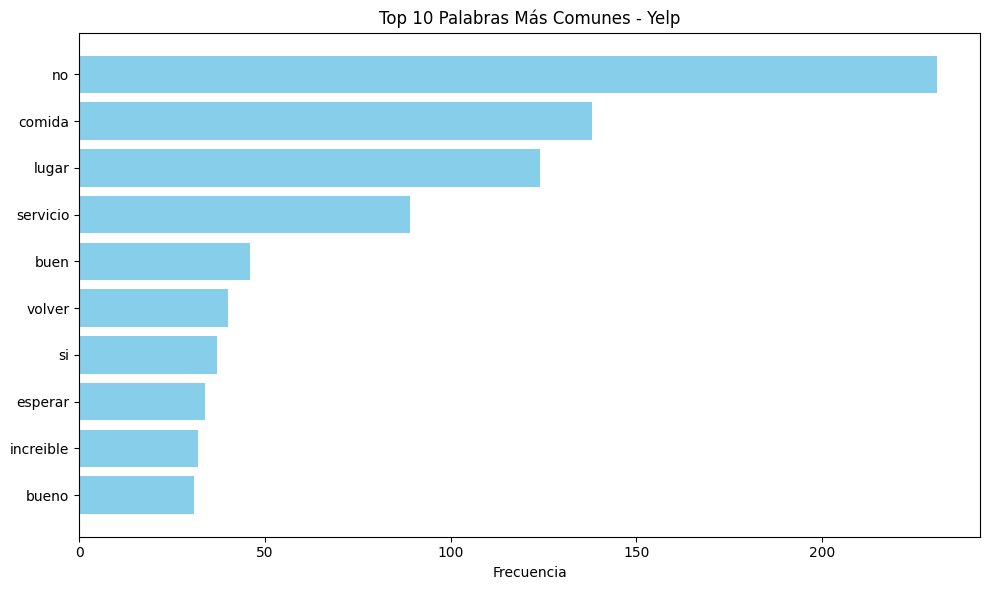

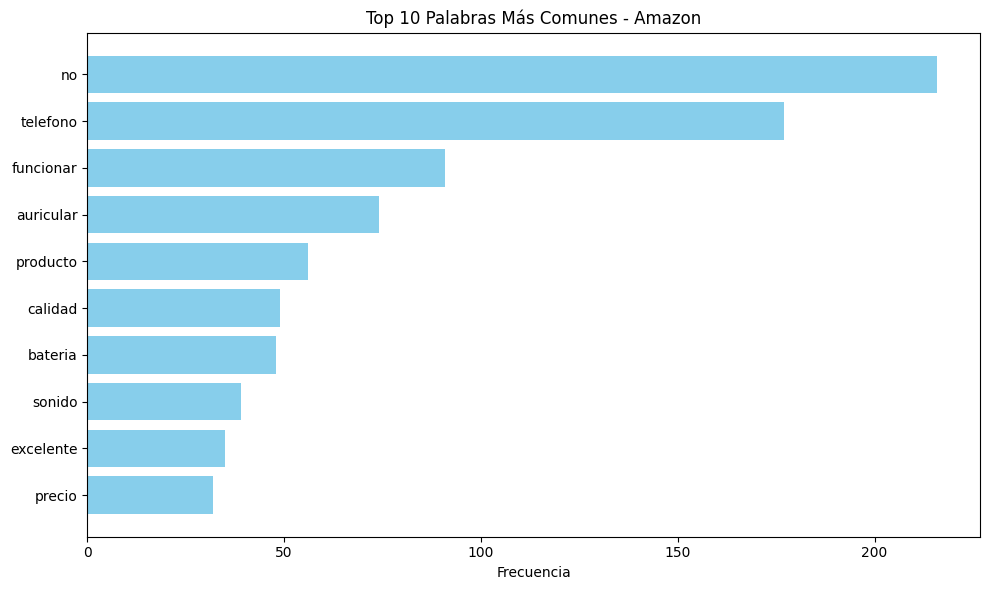

In [27]:
def graficar_palabras_comunes(df, origen, top_n=10):
    # Filtrar y aplanar los lemas
    lemas = [lema for lemas in df[df['Origen'] == origen]['Comentarios_lema'] for lema in lemas]
    conteo = Counter(lemas).most_common(top_n)

    # Separar palabras y frecuencias
    palabras, frecuencias = zip(*conteo)

    # Crear gráfico
    plt.figure(figsize=(10, 6))
    plt.barh(palabras, frecuencias, color='skyblue')
    plt.xlabel('Frecuencia')
    plt.title(f'Top {top_n} Palabras Más Comunes - {origen.capitalize()}')
    plt.gca().invert_yaxis()  # Poner la palabra más común arriba
    plt.tight_layout()
    plt.show()

# Graficar para Yelp
graficar_palabras_comunes(df, 'yelp')

# Graficar para Amazon
graficar_palabras_comunes(df, 'amazon')

### Conteo de bigramas más comunes.

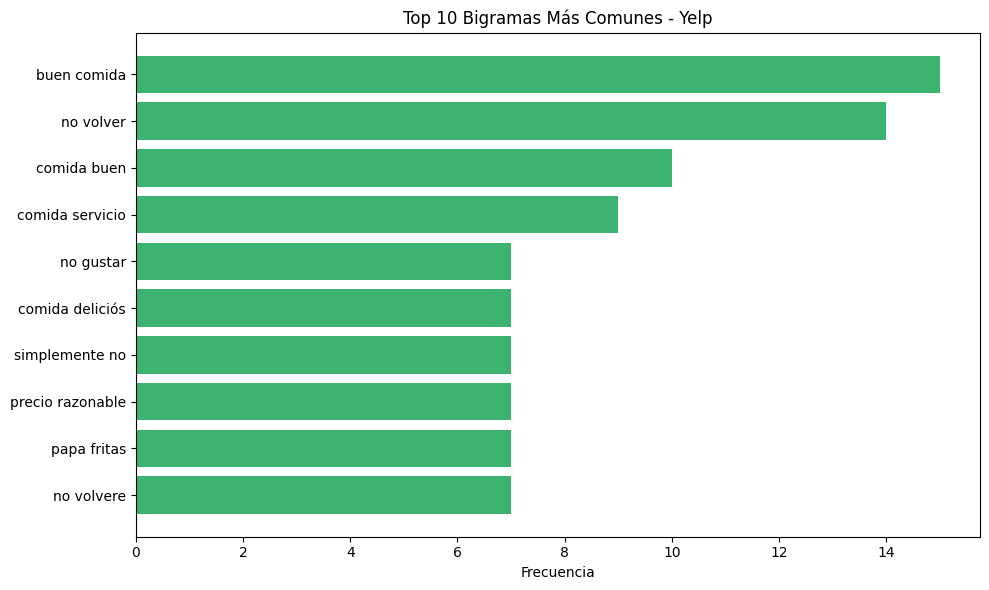

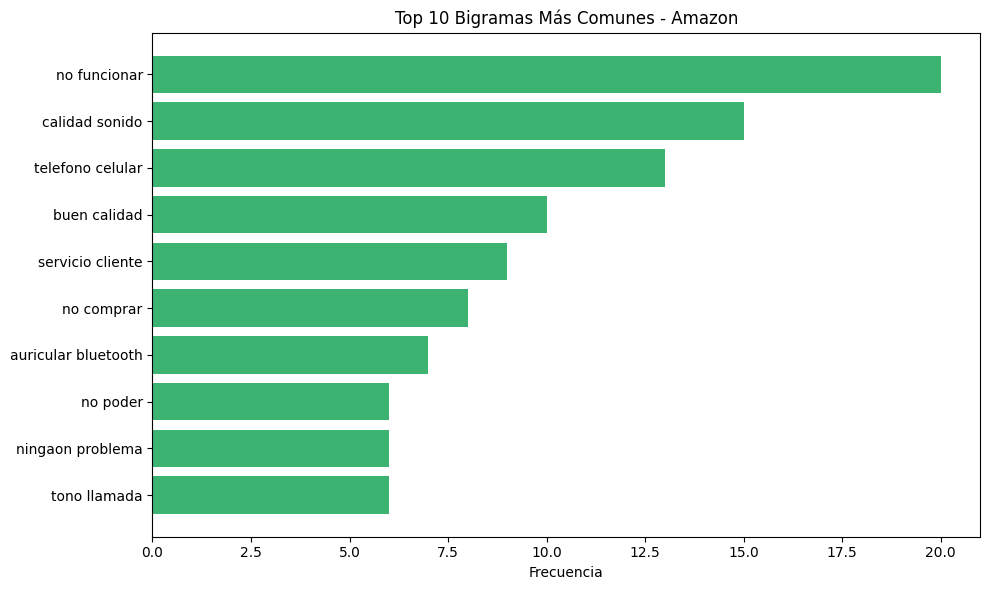

In [26]:
from collections import Counter
from itertools import tee
import matplotlib.pyplot as plt

def generar_bigramas(lista):
    """Devuelve bigramas como tuplas a partir de una lista de palabras"""
    a, b = tee(lista)
    next(b, None)
    return list(zip(a, b))

def graficar_bigramas_comunes(df, origen, top_n=10):
    # Filtrar solo los comentarios del origen y generar bigramas
    bigramas = [
        bigrama
        for lemas in df[df['Origen'] == origen]['Comentarios_lema']
        for bigrama in generar_bigramas(lemas)
    ]

    conteo = Counter(bigramas).most_common(top_n)

    # Convertir tuplas de bigramas a string para graficar
    etiquetas = [' '.join(b) for b, _ in conteo]
    frecuencias = [f for _, f in conteo]

    # Crear gráfico
    plt.figure(figsize=(10, 6))
    plt.barh(etiquetas, frecuencias, color='mediumseagreen')
    plt.xlabel('Frecuencia')
    plt.title(f'Top {top_n} Bigramas Más Comunes - {origen.capitalize()}')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()

# Ejemplo de uso
graficar_bigramas_comunes(df, 'yelp')
graficar_bigramas_comunes(df, 'amazon')


### WordClouds

#### WordCloud Yelp.

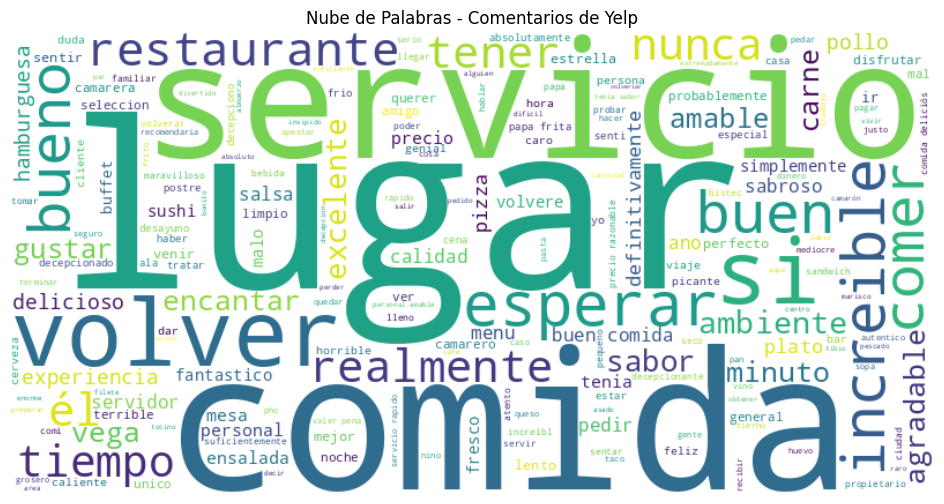

In [28]:
# Filtrar el DataFrame
df_yelp = df[df['Origen'] == 'yelp']

# Unir todos los lemas en un solo string (comentarios lematizados ya están en listas)
texto_yelp = ' '.join([' '.join(lemas) for lemas in df_yelp['Comentarios_lema']])

# Crear la nube de palabras
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(texto_yelp)

# Mostrar la nube
plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Nube de Palabras - Comentarios de Yelp")
plt.show()

#### WordCloud Amazon.

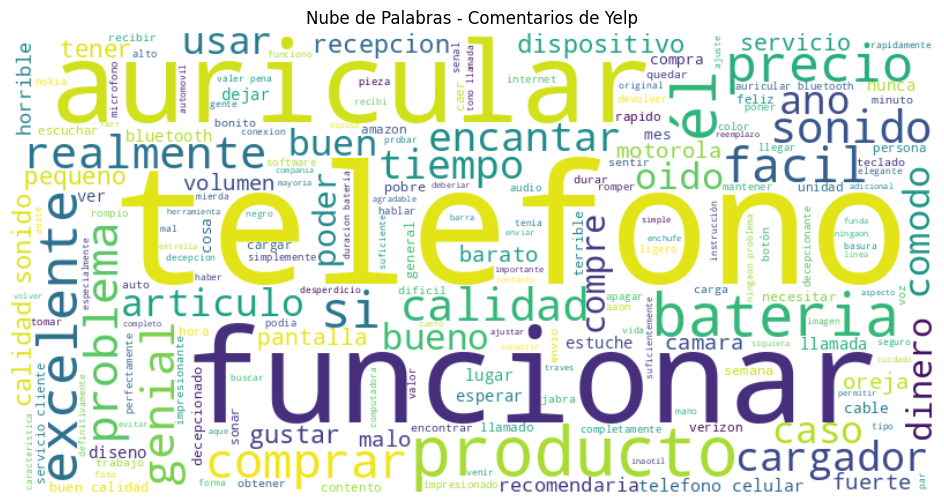

In [29]:
# Filtrar el DataFrame
df_amazon = df[df['Origen'] == 'amazon']

# Unir todos los lemas en un solo string (comentarios lematizados ya están en listas)
texto_amazon = ' '.join([' '.join(lemas) for lemas in df_amazon['Comentarios_lema']])

# Crear la nube de palabras
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(texto_amazon)

# Mostrar la nube
plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Nube de Palabras - Comentarios de Yelp")
plt.show()


#### WordCloud + Bigramas.

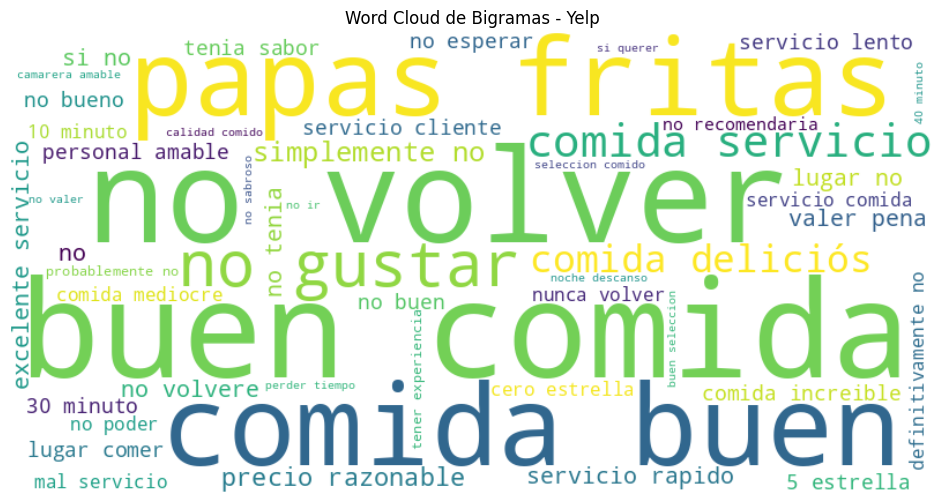

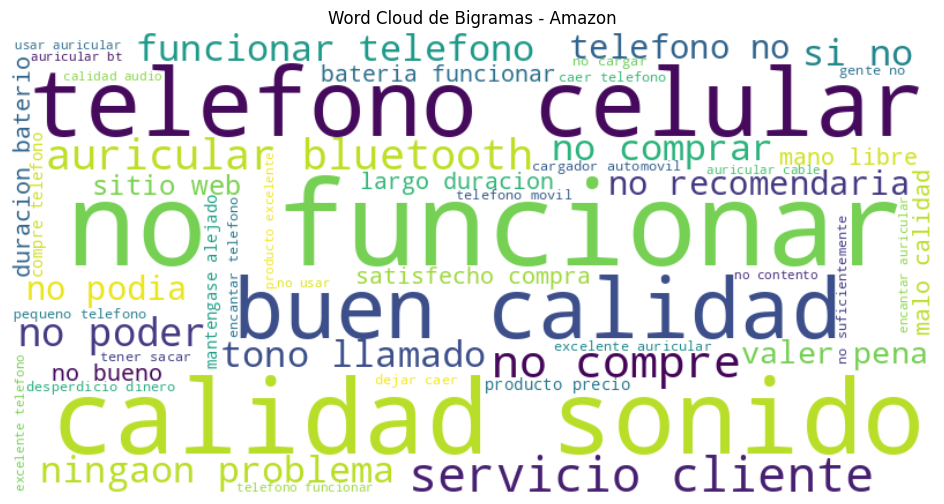

In [47]:
def generar_bigramas_spacy(df, origen, top_n=50):
    """
    Genera bigramas usando spaCy a partir de la columna 'Comentarios_Lema', sin stopwords.
    Luego genera una nube de palabras.
    """
    # Filtrar los comentarios por 'origen' (por ejemplo, 'yelp' o 'amazon')
    comentarios = df[df['Origen'] == origen]['Comentarios_sin_StopWords']

    # Generar bigramas
    bigramas = []
    for comentario in comentarios:
        # Crear un Doc de spaCy a partir de la lista de lemas (de la columna 'Comentarios_Lema')
        doc = nlp(' '.join(comentario))  # Unimos la lista de lemas y lo procesamos con spaCy
        # Extraer bigramas
        for i in range(len(doc) - 1):
            if not doc[i].is_stop and not doc[i+1].is_stop:  # Asegurarse de que no sean stopwords
                bigramas.append((doc[i].lemma_, doc[i+1].lemma_))

    # Contar los bigramas más comunes
    conteo_bigramas = Counter(bigramas).most_common(top_n)

    # Convertir los bigramas a formato texto "palabra1 palabra2"
    bigramas_texto = {' '.join(bigrama): freq for bigrama, freq in conteo_bigramas}

    # Generar la nube de palabras de los bigramas
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(bigramas_texto)

    # Mostrar la nube
    plt.figure(figsize=(12, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(f"Word Cloud de Bigramas - {origen.capitalize()}")
    plt.show()

# Generar la nube de bigramas para Yelp y Amazon
generar_bigramas_spacy(df, 'yelp')
generar_bigramas_spacy(df, 'amazon')

### 🚀 Análisis de sentimiento en español con pysentimiento

In [32]:
# Crear analizador de sentimientos
analyzer = create_analyzer(task="sentiment", lang="es")

# Aplicar a una columna de texto
df['Sentimiento'] = df['Comentario'].apply(lambda x: analyzer.predict(x).output)
# Sentimiento solo guarda lo predicho (POS, NEU o NEG)

df['Probabilidad'] = df['Comentario'].apply(lambda x: analyzer.predict(x).probas)
#Ese diccionario contiene la probabilidad de cada clase: positivo, neutro, negativo Ejemplo: {'POS': 0.84, 'NEU': 0.10, 'NEG': 0.06}.

#### 📊  Gráfico de barras de frecuencia de sentimientos

<ipython-input-33-8869e27892cb>:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='Sentimiento', order=['POS', 'NEU', 'NEG'], palette='pastel')


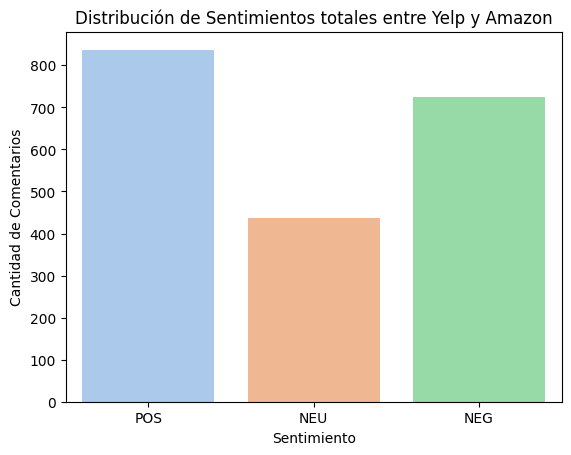

In [33]:
sns.countplot(data=df, x='Sentimiento', order=['POS', 'NEU', 'NEG'], palette='pastel')
plt.title('Distribución de Sentimientos totales entre Yelp y Amazon')
plt.xlabel('Sentimiento')
plt.ylabel('Cantidad de Comentarios')
plt.show()


#### Distribución de los sentimientos.

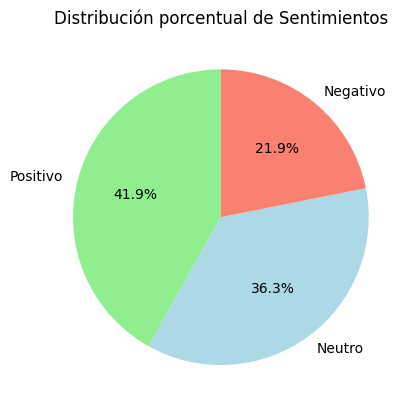

In [34]:
df['Sentimiento'].value_counts().plot.pie(
    autopct='%1.1f%%',
    startangle=90,
    labels=['Positivo', 'Neutro', 'Negativo'],
    colors=['lightgreen', 'lightblue', 'salmon']
)
plt.title('Distribución porcentual de Sentimientos')
plt.ylabel('')
plt.show()

#### Análisis de Confianza para filtrar comentarios con baja certeza

In [35]:
# Máxima probabilidad (nivel de certeza del modelo)
df['Confianza'] = df['Probabilidad'].apply(lambda x: max(x.values()))  # En este caso, de la lista {'POS': 0.84, 'NEU': 0.10, 'NEG': 0.06} sólo guarda 0.84 que es el valor mayor

# Filtrar comentarios cuya confianza sea menor a 0.6
comentarios_baja_confianza = df[df['Confianza'] < 0.6]
comentarios_alta_confianza = df[df['Confianza'] >= 0.6]
# Ver los primeros resultados
#comentarios_baja_confianza[['Comentarios', 'Sentimiento', 'Confianza']]

#### Distribución de los comentarios filtrados.

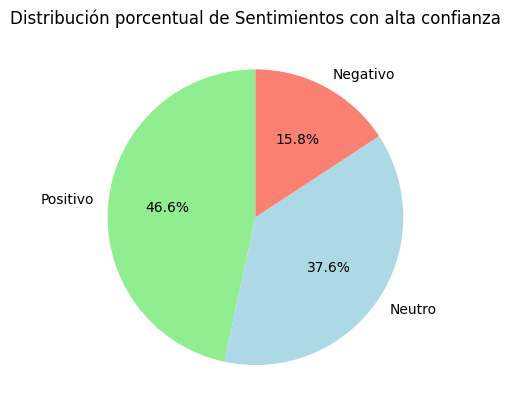

In [38]:
df[df['Confianza'] >= 0.6]['Sentimiento'].value_counts().plot.pie(
    autopct='%1.1f%%',
    startangle=90,
    labels=['Positivo', 'Neutro', 'Negativo'],
    colors=['lightgreen', 'lightblue', 'salmon']
)
plt.title('Distribución porcentual de Sentimientos con alta confianza')
plt.ylabel('')
plt.show()

#### Distribución de la Confianza de los comentarios.

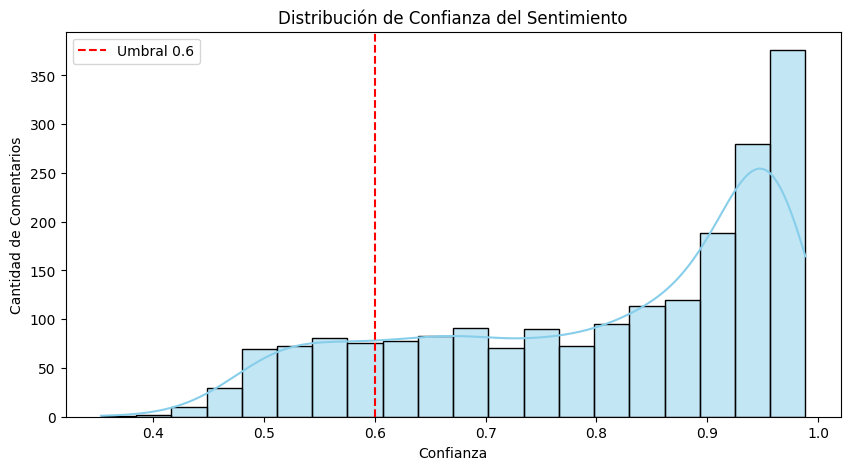

In [39]:
plt.figure(figsize=(10, 5))
sns.histplot(data=df, x='Confianza', bins=20, kde=True, color='skyblue')
plt.axvline(0.6, color='red', linestyle='--', label='Umbral 0.6')
plt.title('Distribución de Confianza del Sentimiento')
plt.xlabel('Confianza')
plt.ylabel('Cantidad de Comentarios')
plt.legend()
plt.show()

# Pruebas de Modelos de Machine Learning.

## Regresión Logística.

### Utilizando TF-IFD.

TF-IDF (Term Frequency - Inverse Document Frequency) es una técnica de procesamiento de texto utilizada para evaluar la importancia de una palabra dentro de un conjunto de documentos. Se basa en dos conceptos:

TF (Frecuencia de Término): Mide cuántas veces aparece un término en un documento específico, comparado con el número total de términos en ese documento. Esto ayuda a capturar cuán relevante es una palabra dentro de un documento en particular.

IDF (Frecuencia Inversa de Documentos): Mide la importancia de una palabra dentro de un conjunto de documentos. Si una palabra aparece en muchos documentos, tiene menos valor. La fórmula es:

Esto ayuda a reducir el peso de las palabras que aparecen frecuentemente en todos los documentos (como "el", "y", "de"), ya que no agregan mucha información.

Así, la importancia de un término en un documento depende tanto de su frecuencia en ese documento como de cuán común es en todo el conjunto de documentos.

In [44]:
 # TFIDF espera trabajar con strings y  no listas, por lo que se procede a crear una nueva columna con los datos tokenizados en formato str.
df['Comentarios_token_str'] = df['Comentarios_sin_StopWords'].apply(lambda x: ' '.join(x))


### Cálculo de TF-IDF con TfidVetorizer.

In [45]:
# Crear el vectorizador
tfidfvectorizer = TfidfVectorizer(ngram_range=(1,3))
#inlcuyo bigramas y trigramas para que le de contexto a los comentarios. Esto me permite ver un "No conforme" y no solamente le "No" y el "Conforme" por separado.

# Ajustar y transformar
tfidf_matrix = tfidfvectorizer.fit_transform(df['Comentarios_token_str'])

# Obtener los términos
features = tfidfvectorizer.get_feature_names_out()

# Convertir la matriz a DataFrame
df_tfidf = pd.DataFrame(tfidf_matrix.toarray(), columns=features)

# Sumar TF-IDF por columna
tfidf_scores = df_tfidf.sum().sort_values(ascending=False)

# Mostrar top 10
print("🔝 Top 10 n-gramas por score TF-IDF:")
print(tfidf_scores.head(10).round(3))




🔝 Top 10 n-gramas por score TF-IDF:
no          54.470
telefono    32.875
servicio    23.779
comida      22.994
lugar       22.895
producto    17.442
funciona    17.354
buena       15.276
calidad     12.612
precio      11.964
dtype: float64


In [46]:
# Crear un DataFrame auxiliar con el tipo de n-grama
df_scores = pd.DataFrame({
    'ngram': tfidf_scores.index,
    'score': tfidf_scores.values,
    'tipo': tfidf_scores.index.to_series().apply(lambda x: f'{len(x.split())}-grama')
})

# Ver los 5 más importantes por tipo
top_n = 5
for tipo in ['1-grama', '2-grama', '3-grama']:
    print(f"\n🔝 Top {top_n} {tipo}s:")
    print(df_scores[df_scores['tipo'] == tipo].head(top_n).to_string(index=False))


🔝 Top 5 1-gramas:
   ngram     score    tipo
      no 54.469626 1-grama
telefono 32.874651 1-grama
servicio 23.779208 1-grama
  comida 22.993750 1-grama
   lugar 22.894560 1-grama

🔝 Top 5 2-gramas:
           ngram    score    tipo
      no volvere 4.415488 2-grama
   no volveremos 4.333206 2-grama
     no funciona 4.185172 2-grama
servicio cliente 4.137256 2-grama
    buena comida 4.025699 2-grama

🔝 Top 5 3-gramas:
                    ngram    score    tipo
    buena comida servicio 1.658375 3-grama
    no recomendaria lugar 1.256881 3-grama
             no vale pena 1.196722 3-grama
servicio cliente terrible 1.117075 3-grama
       no compre producto 1.031673 3-grama


## Redes Neuronales.